# Importing Dependicies

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import pymysql.cursors
from datetime import datetime

# Importing Data

In [37]:
apld = pd.read_pickle('df_diabetes_s1.pickle')

# Data Filtering

In [38]:
# Paid Claims Only
apld = apld[apld['claim_type'].isin(['pd'])]

In [39]:
# Type 2 Diabetes Only
apld = apld[apld['disease_type'].isin(['t2'])]

In [40]:
# 4 Years of Data
apld['service_date'] = pd.to_datetime(apld['service_date'])

apld = apld[apld['service_date'].between('2019-01-01', '2022-12-31')]

# Exploratory Data Analysis 

### Data Structure

In [41]:
apld['claim_id'].head()

0    517566340
1    387782725
2    999807010
3    999807011
4    999807012
Name: claim_id, dtype: int64

In [42]:
apld['claim_id'].nunique()

152782

In [43]:
apld['claim_id'].count()

152791

In [44]:
len_min = apld['claim_id'].astype(str).str.len().min()
len_max = apld['claim_id'].astype(str).str.len().max()
print(' claim_id length min: '+str(len_min), '\n', 'claim_id length max: '+str(len_max))

 claim_id length min: 9 
 claim_id length max: 10


In [45]:
apld['dup'] = apld.duplicated('claim_id', keep=False)
apld['dup'].value_counts()

False    152773
True         18
Name: dup, dtype: int64

In [46]:
dups = apld[apld['dup'] == 1].sort_values(by=['claim_id'])

In [47]:
len(dups['claim_id'].unique())

9

#### 9 duplicate claim_ids


In [48]:
dups.duplicated(['claim_id', 'patient_id'], keep=False).sum()

0

#### ~ even though we have duplicate claim id's they are not duplicate per patient


In [49]:
trend =  apld.groupby(['service_date']).agg({'service_date': 'count', 'claim_id': 'nunique'}).rename(columns={'service_date': 'count', 'claim_id' : 'nunique'})
trend = trend.resample('M').sum()

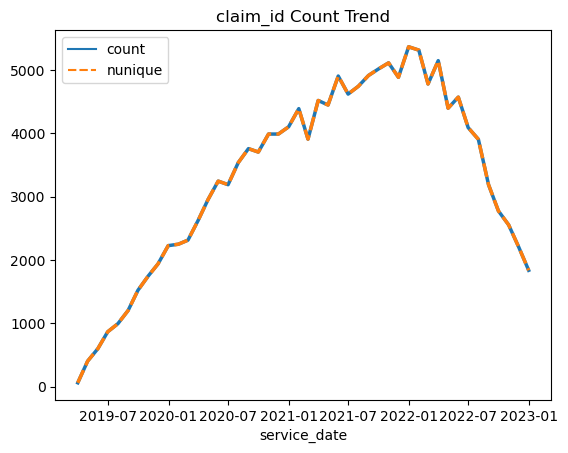

In [50]:
sns.lineplot(data=trend, palette='tab10', linewidth=2.5).set_title('claim_id Count Trend')
plt.show()

#### # ~claim_id count trend: there is an issue in the claim_id count trend, it is downward trending

### Patient ID

In [51]:
apld['patient_id'].head(10)

0    20006
1    20006
2    20006
3    20006
4    20006
5    20006
6    20006
7    20006
8    20006
9    20006
Name: patient_id, dtype: int64

In [52]:
apld['patient_id'].nunique()

9027

#### ~  9,027 unique patients

In [53]:
len_min = apld['patient_id'].astype(str).str.len().min()
len_max = apld['patient_id'].astype(str).str.len().max()
print(' patient_id length min: '+str(len_min), '\n', 'patient_id length max: '+str(len_max))

 patient_id length min: 5 
 patient_id length max: 5


In [54]:
# trend
trend =  apld.groupby(['service_date']).agg({'service_date': 'count', 'patient_id': 'nunique'}).rename(columns={'service_date': 'count', 'patient_id' : 'nunique'})
trend = trend.resample('M').sum()

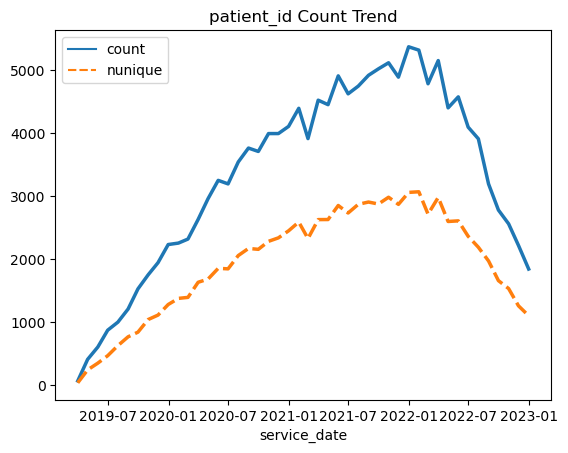

In [55]:
sns.lineplot(data=trend, palette='tab10', linewidth=2.5).set_title('patient_id Count Trend')
plt.show()

### Service Date & Claim Type

In [56]:
apld['claim_type'].unique()

array(['pd'], dtype=object)

In [57]:
apld['claim_type'].nunique()

1

In [58]:
apld['service_date'].min()

Timestamp('2019-03-28 00:00:00')

In [59]:
apld['service_date'].max()

Timestamp('2022-12-31 00:00:00')

### Days Supply

In [60]:
ds_sd, ds_ed = apld['days_supply'].min(), apld['days_supply'].max()
print(apld_ds_sd , apld_ds_ed)

15 90


In [61]:
apld['days_supply'].unique()

array([45, 60, 90, 30, 15, 75])

In [62]:
apld['days_supply'].value_counts(normalize=True).round(2)

45    0.25
30    0.25
60    0.24
90    0.24
15    0.01
75    0.01
Name: days_supply, dtype: float64

### Quantity